# Statistical Process Control and Machine Learning

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from ControlCharts import ShewhartControlModel

## Read and Data Processing

In [156]:
# Read original data set
data= pd.read_csv('insurance.csv')
data_dummy= pd.get_dummies(data)
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Figure size 432x288 with 0 Axes>

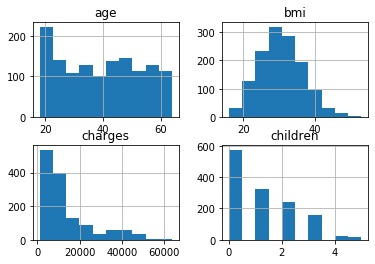

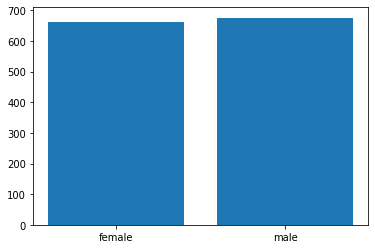

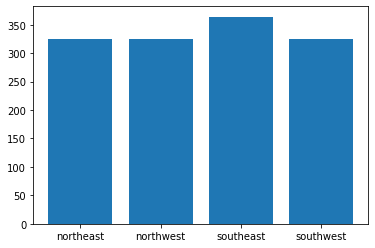

In [157]:
# Describe numeric features
display(data.describe())

# Visualize numeric features
plt.figure()
data.hist()
plt.show()
plt.close()

# Visualize Dummy Variables
count_data= data[['age', 'sex', 'region']]
sex_analysis= count_data.groupby(by= 'sex').count()
region_analysis= count_data.groupby(by= 'region').count()

# Visualize Sex Variables
plt.figure()
plt.bar(sex_analysis.index.values,sex_analysis['age'].values)
plt.show()
plt.close()

# Visualize Region Variables
plt.figure()
plt.bar(region_analysis.index.values,region_analysis['age'].values)
plt.show()
plt.close()


## Training Initial Model

In [158]:
# Output Storage
ms_error_train= []
map_error_train= []

# Split in feature matrix and prediction vector
mid_point= int(data.shape[0]/2)
X_training= data_dummy.iloc[:mid_point, :-1].values
y_training= data.iloc[:mid_point,-1].values

# Train Initial Model
model= LinearRegression()



tscv = TimeSeriesSplit(n_splits=20)
model= LinearRegression()
# Train and Test: Generating Simulated Data for SPC
for train_index, test_index in tscv.split(X_training):
    X_train, X_test = X_training[train_index], X_training[test_index]
    y_train, y_test = y_training[train_index], y_training[test_index]
    
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    MSE= mean_squared_error(y_test, y_pred)
    MAPE= np.average((np.absolute((y_test-y_pred))/y_test)*100)
    ms_error_train.append(MSE)
    map_error_train.append(MAPE)

## Deployment Monitoring Using SPC

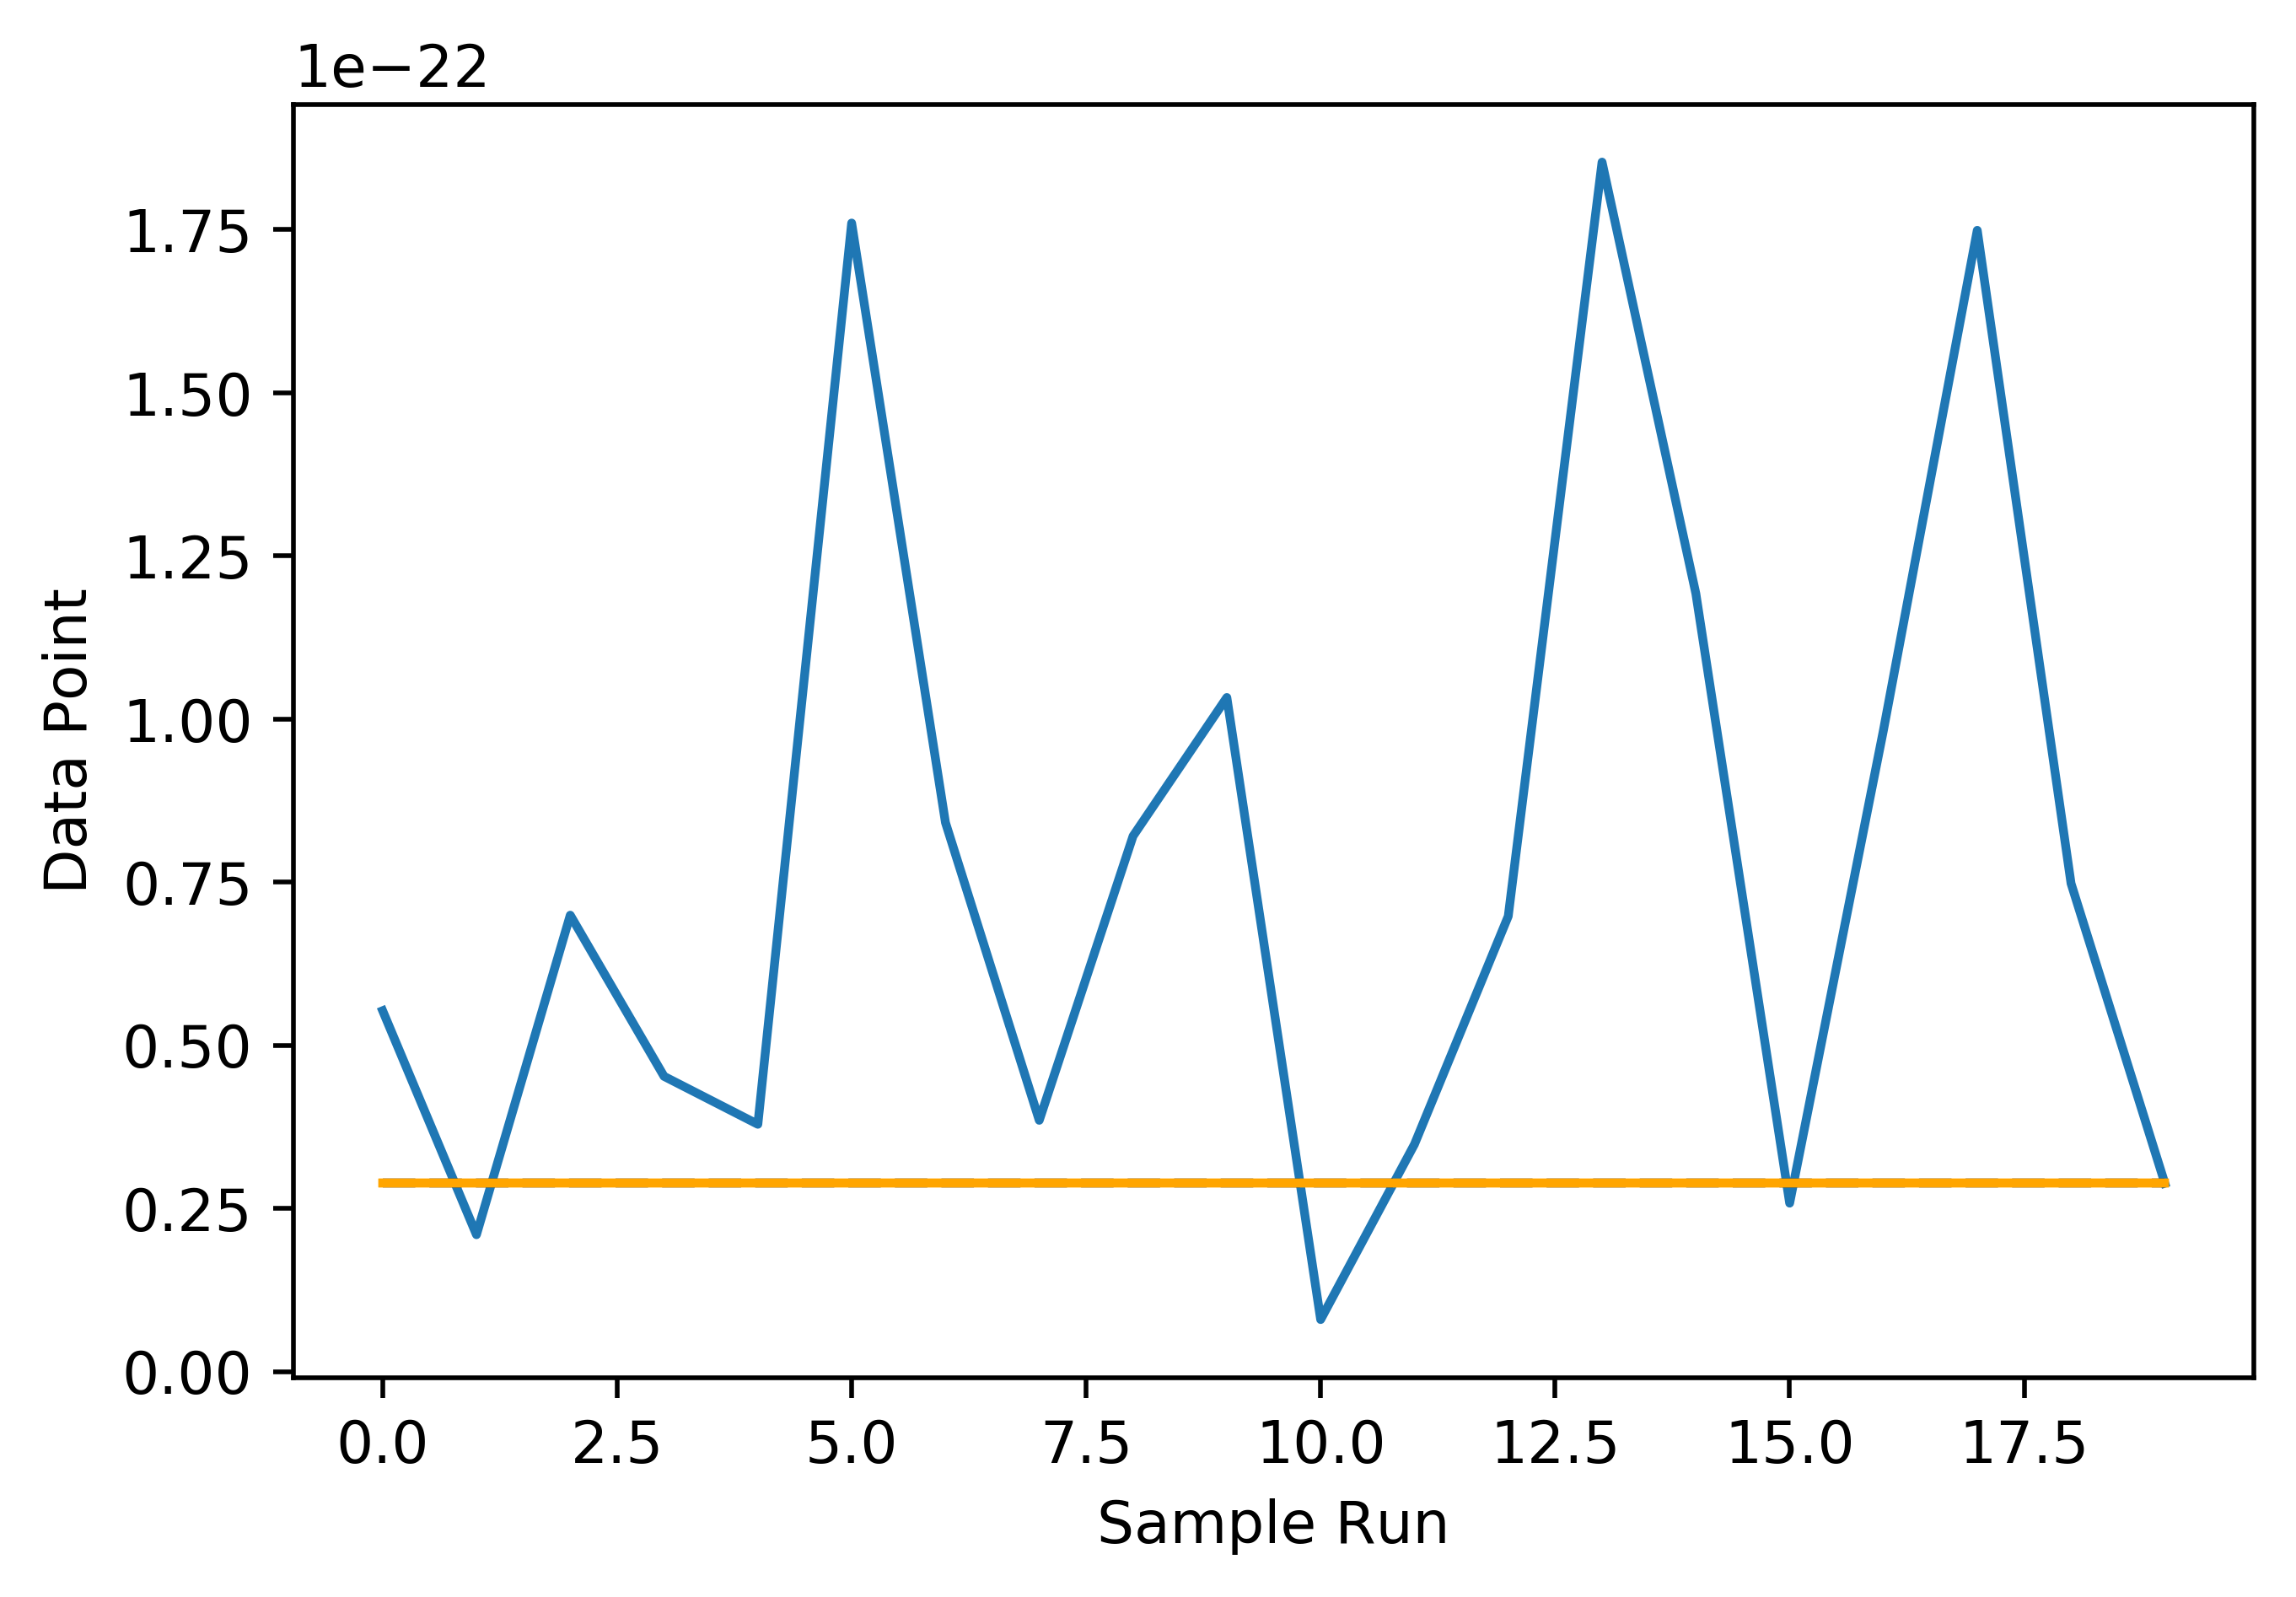

In [161]:
# Output Storage
ms_error_test= []
map_error_test= []

# Validation data
X_future= data_dummy.iloc[mid_point:, :-1].values
y_future= data.iloc[mid_point:,-1].values

for train_index, test_index in tscv.split(X_training):
    X_train, X_test = X_future[train_index], X_future[test_index]
    y_train, y_test = y_future[train_index], y_future[test_index]
    
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    MSE= mean_squared_error(y_test, y_pred)
    MAPE= np.average((np.absolute((y_test-y_pred))/y_test)*100)
    ms_error_test.append(MSE)
    map_error_test.append(MAPE)

# Calculate the Mean and Standard Deviation
miu_train= np.average(MSE)
sigma= np.std(MSE)

spc_model= ShewhartControlModel(k=3)
spc_model.fit(miu=miu_train, sigma=sigma)
ooc= spc_model.predict(np.array(ms_error_test))
spc_model.plot(np.array(ms_error_test))
